[11:31:13] Explicit valence for atom # 0 N, 5, is greater than permitted
[11:31:13] Can't kekulize mol.  Unkekulized atoms: 9
[11:31:16] Can't kekulize mol.  Unkekulized atoms: 4
[11:31:16] Can't kekulize mol.  Unkekulized atoms: 4


Removed 4 invalid SMILES


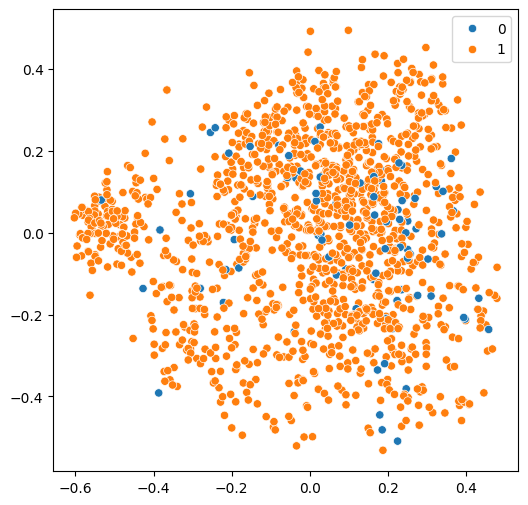

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import MACCSkeys
import numpy as np
from qiskit_aer import Aer
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from qiskit.circuit.library import ZZFeatureMap
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Clintox dataset
clintox_data = pd.read_csv('clintox.csv')  # Adjust the path to your dataset

# Extract SMILES and labels
smiles_list = clintox_data['smiles']
labels = clintox_data['FDA_APPROVED']  # Adjust the column name to match your dataset

# Function to generate MACCS keys
def smiles_to_maccs(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        maccs = MACCSkeys.GenMACCSKeys(mol)
        return np.array(maccs)
    else:
        return None

maccs_keys = [smiles_to_maccs(smiles) for smiles in smiles_list]

# Remove None entries resulting from invalid SMILES
valid_data = [(maccs, label) for maccs, label in zip(maccs_keys, labels) if maccs is not None]
if len(valid_data) != len(smiles_list):
    print(f"Removed {len(smiles_list) - len(valid_data)} invalid SMILES")

# Separate fingerprints and labels again
maccs_keys, labels = zip(*valid_data)

# Normalize the MACCS keys
def normalize_vector(vector):
    norm = np.linalg.norm(vector)
    if norm == 0:
        return vector
    return vector / norm

normalized_maccs_keys = [normalize_vector(maccs) for maccs in maccs_keys]

# Apply PCA for dimensionality reduction
features = PCA(n_components=4).fit_transform(normalized_maccs_keys)

plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=labels, palette="tab10")
plt.show()

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)



In [3]:
import pennylane as qml
from pennylane import numpy as np

n_qubits = 4
dev = qml.device('default.qubit', wires=n_qubits)

@qml.qnode(dev)
def quantum_encoder(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

@qml.qnode(dev)
def quantum_decoder(encoded, weights):
    qml.templates.AngleEmbedding(encoded, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

# Initializing weights
encoder_weights = np.random.randn(3, n_qubits, 3)
decoder_weights = np.random.randn(3, n_qubits, 3)


In [4]:
def encoder(x, weights):
    return quantum_encoder(x, weights)

def decoder(x, weights):
    return quantum_decoder(x, weights)

def autoencoder(x, enc_weights, dec_weights):
    encoded = encoder(x, enc_weights)
    decoded = decoder(encoded, dec_weights)
    return decoded


In [6]:
from scipy.optimize import minimize

# Loss function
def loss(weights):
    enc_weights = weights[:3 * n_qubits * 3].reshape(3, n_qubits, 3)
    dec_weights = weights[3 * n_qubits * 3:].reshape(3, n_qubits, 3)
    loss = 0
    for i in range(len(X_train)):
        x = X_train[i]
        reconstructed = autoencoder(x, enc_weights, dec_weights)
        loss += np.mean((reconstructed - x)**2)
    return loss / len(X_train)

# Training
init_params = np.concatenate([encoder_weights.flatten(), decoder_weights.flatten()])
opt = minimize(loss, init_params, method='BFGS', options={'maxiter': 10})

# Get the optimized weights
opt_weights = opt.x
enc_weights_opt = opt_weights[:3 * n_qubits * 3].reshape(3, n_qubits, 3)
dec_weights_opt = opt_weights[3 * n_qubits * 3:].reshape(3, n_qubits, 3)


In [ ]:
# Evaluate the model
def evaluate(X, enc_weights, dec_weights):
    total_loss = 0
    for i in range(len(X)):
        x = X[i]
        reconstructed = autoencoder(x, enc_weights, dec_weights)
        total_loss += np.mean((reconstructed - x)**2)
    return total_loss / len(X)

train_loss = evaluate(X_train, enc_weights_opt, dec_weights_opt)
test_loss = evaluate(X_test, enc_weights_opt, dec_weights_opt)

print(f'Train Loss: {train_loss:.4f}')
print(f'Test Loss: {test_loss:.4f}')


Train Loss: 0.0322
Test Loss: 0.0341


In [8]:
def accuracy(X, enc_weights, dec_weights, threshold=0.1):
    correct = 0
    for i in range(len(X)):
        x = X[i]
        reconstructed = autoencoder(x, enc_weights, dec_weights)
        if np.mean((reconstructed - x)**2) < threshold:
            correct += 1
    return correct / len(X)

train_accuracy = accuracy(X_train, enc_weights_opt, dec_weights_opt)
test_accuracy = accuracy(X_test, enc_weights_opt, dec_weights_opt)

print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Train Accuracy: 0.9865
Test Accuracy: 0.9932
